In [1]:
import polars as pl
import matplotlib.pyplot as plt
import blitzbeaver as bb

pl.Config.set_tbl_rows(-1)

polars.config.Config

In [2]:
csv_path = "../../aptihramy/data/csv_cleaned"

start_year = 1835
end_year = 1892

dataframes = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(start_year, end_year + 1)
]

In [3]:
# we need to cap the string values to a maximum of 256 characters
# to avoid issues in the computation of the levenshtein distance

for i in range(len(dataframes)):
    df = dataframes[i]
    dataframes[i] = df.with_columns(
        df["enfants_chez_parents_prenom"]
        .str.split("|")
        .list.eval(pl.element().filter(pl.element() != "").slice(0, 256))
        .alias("enfants_chez_parents_prenom"),
        df["nom_rue"].str.slice(0, 256).alias("nom_rue"),
        df["chef_prenom"].str.slice(0, 256).alias("chef_prenom"),
        df["chef_nom"].str.slice(0, 256).alias("chef_nom"),
        df["chef_origine"].str.slice(0, 256).alias("chef_origine"),
        df["epouse_nom"].str.slice(0, 256).alias("epouse_nom"),
        df["chef_vocation"].str.slice(0, 256).alias("chef_vocation"),
    )

In [4]:
# load the graph from a .beaver file
path_graph = "../graph_whole.beaver"

graph = bb.read_beaver(path_graph)

In [5]:
record_schema = bb.RecordSchema(
    [
        bb.FieldSchema("nom_rue", bb.ElementType.String),
        bb.FieldSchema("chef_prenom", bb.ElementType.String),
        bb.FieldSchema("chef_nom", bb.ElementType.String),
        bb.FieldSchema("chef_origine", bb.ElementType.String),
        bb.FieldSchema("epouse_nom", bb.ElementType.String),
        bb.FieldSchema("chef_vocation", bb.ElementType.String),
        bb.FieldSchema("enfants_chez_parents_prenom", bb.ElementType.MultiStrings),
    ]
)

In [6]:
distance_metric_config = bb.DistanceMetricConfig(
    metric="lv_opti",
    caching_threshold=4,
    use_sigmoid=False,
    lv_substring_weight=0.5,
)
normal_memory_config = bb.MemoryConfig(
    memory_strategy="median",
)
multi_memory_config = bb.MemoryConfig(
    memory_strategy="mw-median",
    multiword_threshold_match=0.6,
    multiword_distance_metric=distance_metric_config,
)

config = bb.config(
    record_schema=record_schema,
    distance_metric_config=distance_metric_config,
    record_scorer_config=bb.RecordScorerConfig(
        record_scorer="average",
        weights=None,
        min_weight_ratio=None
    ),
    resolver_config=bb.ResolverConfig(
        resolving_strategy="best-match",
    ),
    memory_config=normal_memory_config,
    multistring_memory_config=multi_memory_config,
    interest_threshold=0.6,
    limit_no_match_streak=3,
    num_threads=10,
)

In [7]:
config = bb.deserialize_tracking_config(
    {
        "num_threads": 17,
        "tracker": {
            "interest_threshold": 0.800000011920929,
            "limit_no_match_streak": 4,
            "record_scorer": {
                "record_scorer": "weighted-average",
                "weights": [
                    0.10000000149011612,
                    0.30000001192092896,
                    0.30000001192092896,
                    0.30000001192092896,
                    0.10000000149011612,
                    0.10000000149011612,
                    0.10000000149011612,
                ],
                "min_weight_ratio": 0.6000000238418579,
            },
            "memories": [
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "mw-median",
                    "multiword_threshold_match": 0.800000011920929,
                    "multiword_distance_metric": {
                        "metric": "lv_opti",
                        "caching_threshold": 4,
                        "use_sigmoid": False,
                        "lv_edit_weights": None,
                        "lv_substring_weight": None,
                        "lv_multiword_separator": None,
                    },
                },
            ],
        },
        "distance_metric": {
            "metric": "lv_substring",
            "caching_threshold": 4,
            "use_sigmoid": False,
            "lv_edit_weights": None,
            "lv_substring_weight": 0.6000000238418579,
            "lv_multiword_separator": None,
        },
        "resolver": {"resolving_strategy": "best-match"},
    }
)

In [ ]:
# compute the graph
graph = bb.execute_tracking(config, record_schema, dataframes, "debug")

Number of chains: 89950
Percentage of matching records: 72.59%
Percentage of matching trackers: 86.11%
Percentage of divergences: 15.53%
Percentage of conflicts: 26.33%


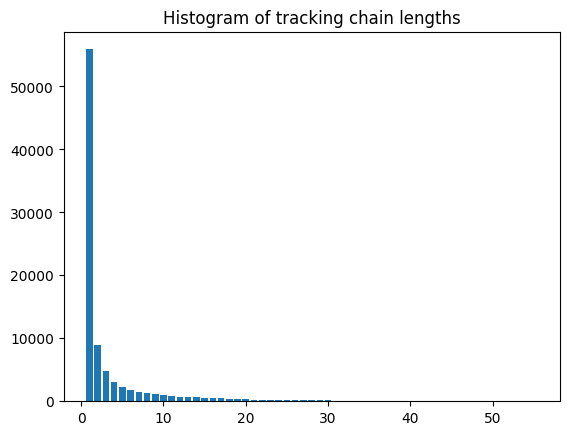

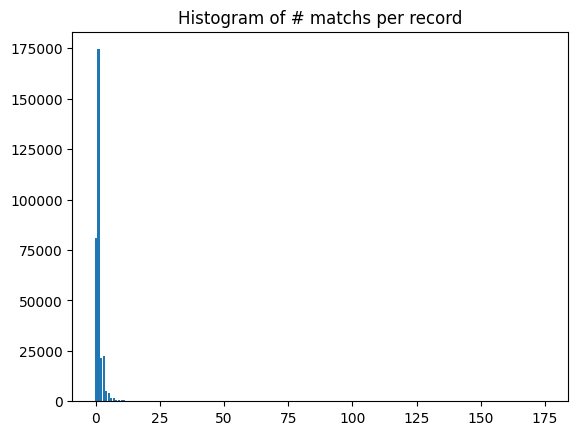

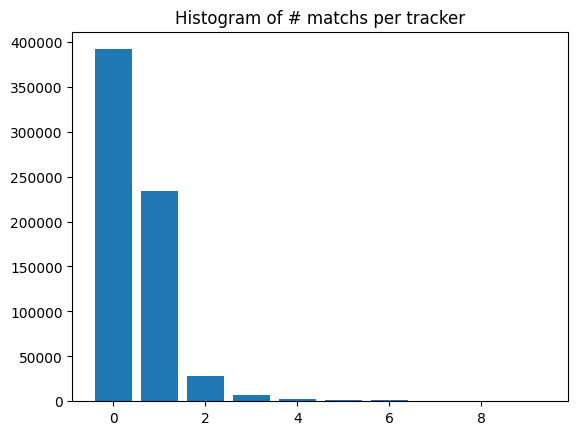

In [8]:
def aggregate_histograms(histograms: list[list[int]]) -> list[int]:
    """
    Aggregates a list of histograms into a single histogram.
    """
    max_len = max([len(h) for h in histograms])
    result = [0] * max_len
    for h in histograms:
        for i, v in enumerate(h):
            result[i] += v
    return result

def summary_graph(graph: bb.TrackingGraph):

    # compute the sum of the histograms for all frames
    histogram_records = aggregate_histograms([resolving.histogram_record_matchs for resolving in graph.diagnostics.resolvings])
    # do not show beyond 10 elements as the counts are very low
    histogram_records = histogram_records
    histogram_trackers = aggregate_histograms([resolving.histogram_tracker_matchs for resolving in graph.diagnostics.resolvings])
    histogram_trackers = histogram_trackers[:10]

    chain_metrics = bb.evaluate_tracking_chain_length(graph._raw)
    graph_metrics = bb.evaluate_tracking_graph_properties(graph._raw)
        
    records_match_ratios = graph_metrics.records_match_ratios[1:]
    trackers_match_ratios = graph_metrics.trackers_match_ratios[1:-1]
    avg_records_match = sum(records_match_ratios) / len(records_match_ratios)
    avg_trackers_match = sum(trackers_match_ratios) / len(trackers_match_ratios)

    per_divergence = sum(histogram_trackers[2:]) / sum(histogram_trackers[1:])
    per_conflict = sum(histogram_records[2:]) / sum(histogram_records[1:])

    # total number of trackers created
    print(f"Number of chains: {len(graph.trackers_ids)}")
    # average percentage of records that have been match with an existing tracker
    print(f"Percentage of matching records: {avg_records_match*100:.2f}%")
    # average percentage of trackers that have match with a record of the current frame
    print(f"Percentage of matching trackers: {avg_trackers_match*100:.2f}%")
    # number of times a tracker matched with more that one record
    # divided by the number of times a tracker matched with a record
    print(f"Percentage of divergences: {per_divergence*100:.2f}%")
    # number of times a record matched with multiple trackers
    # divided by the number of times a record matched with a tracker
    print(f"Percentage of conflicts: {per_conflict*100:.2f}%")

    plt.bar(range(1, len(chain_metrics.histogram)), chain_metrics.histogram[1:])
    plt.title("Histogram of tracking chain lengths")
    plt.show()

    plt.bar(range(len(histogram_records)), histogram_records)
    plt.title("Histogram of # matchs per record")
    plt.show()

    plt.bar(range(len(histogram_trackers)), histogram_trackers)
    plt.title("Histogram of # matchs per tracker")
    plt.show()
    
summary_graph(graph)

In [ ]:
path_graph = "../graph.beaver"

bb.save_beaver(path_graph, graph)

In [9]:
normalization_config = bb.NormalizationConfig(
    threshold_cluster_match=0.5,
    min_cluster_size=2,
    distance_metric=config.distance_metric,
)

In [10]:
normalized_dfs = bb.execute_normalization(
    normalization_config,
    record_schema,
    graph,
    dataframes,
)

In [11]:
def find_chain_with_length(graph: bb.TrackingGraph, start_idx: int, length: int) -> None:
    idx = start_idx
    while idx < len(graph.trackers_ids):
        tracker_id = graph.trackers_ids[idx]
        chain = graph._raw.get_tracking_chain(tracker_id)
        if len(chain) >= length:
            return tracker_id
        idx += 1
    return None

In [38]:
# chain = find_chain_with_length(graph, dataframes, record_schema, 0, 3)
# tracker_id = find_chain_with_length(graph, 2000, 20)
tracker_id = 17538935117787232950
chain = graph.materialize_tracking_chain(tracker_id, dataframes, record_schema, normalized_dfs)
chain.as_dataframe()

frame_idx,nom_rue,chef_prenom,chef_nom,chef_origine,epouse_nom,chef_vocation,enfants_chez_parents_prenom
i64,str,str,str,str,str,str,list[str]
5,"""cour""","""louis|louis""","""combernoux""","""corporation""","""louise panchaud""","""jardinier""",null
6,"""fabrique""","""louis""","""combernoud""","""corporation""","""louise panchaud .""","""jardinier""","[""henriette""]"
7,"""cours""","""louis""","""combernous""","""corgoration""","""lse panchaud""","""jardinier""","[""henriette"", ""marie""]"
9,"""cour""","""louis""","""combernous""","""corpn fse""","""lse panchaud""","""jardinier""","[""henriette"", ""marie"", ""samuel""]"
10,"""cour""","""louis""","""combernous""","""corporation""","""lse panchaud""","""jardinier""","[""henriette"", ""marie"", ""samuel""]"
11,"""cour""","""louis""","""combernous""","""conpn fse""","""lse panchaud""",null,"[""henriette"", ""marie"", ""samuel""]"
13,"""cour bellerive""","""louis""","""combernous""","""corpn fse""","""lse panchaud""","""jardinier""","[""henriette"", ""marie"", … ""louise""]"
14,"""cour""","""louis""","""combernous""","""copple""","""ls panchaud|""","""jardinier""","[""henriette marie samuel""]"
15,"""cour""","""louis""","""combernous""","""corp""","""le panchaud""","""jardinier""",null


In [37]:
chain.as_dataframe(normalized=True)

frame_idx,nom_rue,chef_prenom,chef_nom,chef_origine,epouse_nom,chef_vocation,enfants_chez_parents_prenom
i64,str,str,str,str,str,str,list[str]
0,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny"", ""louis""]"
1,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny"", ""louis""]"
2,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny"", ""louis""]"
3,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny"", ""louis""]"
4,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny"", ""louis""]"
5,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny""]"
6,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny""]"
7,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny""]"
8,"""cour""","""henri""","""combernous""","""corpn fse""","""mie baridon""","""jardinier""","[""georges"", ""jenny""]"


In [ ]:
df = chain.as_dataframe()

In [23]:
genealogy_config = bb.GenealogyConfig(
    husband_name_idx=1,
    wife_name_idx=4,
    last_name_idx=2,
    children_idx=6,
    min_tracking_chain_length=10,
    min_child_count=5,
    search_last_frame_child=False,
    search_year_range=1,
    matching_threshold=0.9,
)

In [24]:
raw_genealogy_trees = bb.execute_genealogy_process(
    genealogy_config,
    distance_metric_config=config.distance_metric,
    record_schema=record_schema,
    tracking_graph=graph._raw,
    dataframes=normalized_dfs,
)

In [25]:
import json


genealogy_trees = json.loads(raw_genealogy_trees)

In [26]:
def get_tree_depth(tree: dict) -> int:
    """
    Returns the depth of the tree.
    """
    if len(tree["children"]) == 0:
        return 1
    return 1 + max(get_tree_depth(child) for child in tree["children"])

def get_tree_depth_husband(tree: dict) -> int:
    """
    Returns the depth of the tree.
    """
    if not tree["is_husband"]:
        return 0
    if len(tree["children"]) == 0:
        return 1
    return 1 + max(get_tree_depth_husband(child) for child in tree["children"])

depths = [0 for i in range(10)]

for tree in genealogy_trees:
    depth = get_tree_depth(tree)
    if depth < 10:
        depths[depth] += 1
    else:
        print(f"Tree with depth {depth} found")

In [27]:
depths

[0, 0, 1564, 201, 22, 0, 0, 0, 0, 0]

In [34]:
genealogy_trees[13]

{'id': 17047012777378778910,
 'is_husband': True,
 'children': [{'id': 2053979435718625468,
   'is_husband': False,
   'children': [{'id': 2902202702171136808,
     'is_husband': True,
     'children': [],
     'leaf_children': []}],
   'leaf_children': []},
  {'id': 2118430769085354166,
   'is_husband': False,
   'children': [],
   'leaf_children': []},
  {'id': 17963529665389979561,
   'is_husband': False,
   'children': [],
   'leaf_children': []},
  {'id': 14393421560522056081,
   'is_husband': False,
   'children': [],
   'leaf_children': []},
  {'id': 8881711425100918396,
   'is_husband': False,
   'children': [],
   'leaf_children': []}],
 'leaf_children': []}